In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle

In [ ]:
with open('/content/drive/MyDrive/Dissertation/dataset/data/BERT_features.pkl', 'rb') as fp:
  textFeatures = pickle.load(fp)

In [ ]:
print(textFeatures.keys())

dict_keys(['Data', 'words', 'level'])


In [ ]:
print(len(textFeatures['Data']))

22413


In [ ]:
import numpy as np
import h5py
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, recall_score, precision_score
import seaborn as sns

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Train Data

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/data/rawSentence-Train-Final.csv")
display(train_df.head())

,Sentence,Sentence Length
0,independence we are only bound by human rights...,19
1,sp sp sp sp we scrutinize what governments wha...,20
2,sp sp sp sp sp sp sp sp sp sp sp sp sp sp inde...,20
3,sp sp sp sp work we help the states to impleme...,20
4,us to do that effectively we need to be indepe...,20


In [ ]:
emo_df_train = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/csv_files/eTrain.csv")
display(emo_df_train.head()) 

,Anger,Disgust,Fear,Happy,Sad,Surprise
0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_df_final = pd.concat([train_df, emo_df_train], axis = 1)
display(train_df_final.head())

,Sentence,Sentence Length,Anger,Disgust,Fear,Happy,Sad,Surprise
0,independence we are only bound by human rights...,19,0.0,1.0,0.0,0.0,0.0,0.0
1,sp sp sp sp we scrutinize what governments wha...,20,1.0,0.0,0.0,0.0,0.0,0.0
2,sp sp sp sp sp sp sp sp sp sp sp sp sp sp inde...,20,1.0,0.0,0.0,0.0,0.0,0.0
3,sp sp sp sp work we help the states to impleme...,20,1.0,0.0,0.0,0.0,0.0,0.0
4,us to do that effectively we need to be indepe...,20,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(type(train_df_final["Anger"]))

<class 'pandas.core.series.Series'>


In [ ]:
train_df_final.drop("Sentence Length", axis=1, inplace=True)
display(train_df_final.head())

,Sentence,Anger,Disgust,Fear,Happy,Sad,Surprise
0,independence we are only bound by human rights...,0.0,1.0,0.0,0.0,0.0,0.0
1,sp sp sp sp we scrutinize what governments wha...,1.0,0.0,0.0,0.0,0.0,0.0
2,sp sp sp sp sp sp sp sp sp sp sp sp sp sp inde...,1.0,0.0,0.0,0.0,0.0,0.0
3,sp sp sp sp work we help the states to impleme...,1.0,0.0,0.0,0.0,0.0,0.0
4,us to do that effectively we need to be indepe...,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(train_df_final.shape)
print(len(train_df_final))

(15290, 7)
15290


In [ ]:
trainTextList = textFeatures['Data'][:len(train_df_final)].tolist()
print(len(trainTextList))

15290


In [ ]:
print(len(trainTextList[1]))

768


In [ ]:
trainTextArr = np.array(trainTextList)
print(type(trainTextArr))
print(trainTextArr.shape)

<class 'numpy.ndarray'>
(15290, 768)


In [ ]:
df_Surprise_labels_Train = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/labels/mosi2uni_Train_labels_surprise.csv",header=None)
df_Angry_labels_Train = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/labels/mosi2uni_Train_labels_angry.csv",header=None)
df_Disgust_labels_Train = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/labels/mosi2uni_Train_labels_disgust.csv",header=None)
df_Fear_labels_Train = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/labels/mosi2uni_Train_labels_fear.csv",header=None)
df_Happy_labels_Train = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/labels/mosi2uni_Train_labels_happy.csv",header=None)
df_Sad_labels_Train = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/labels/mosi2uni_Train_labels_sad.csv",header=None)

In [ ]:
print("-----------TRAIN of VIDEO modality-----------")
dataMosei_train_video = h5py.File("/content/drive/MyDrive/Dissertation/dataset/data/video_train.h5", "r")

video_trainKeys = []
for key in dataMosei_train_video.keys():
    video_trainKeys.append(key)
print(video_trainKeys)

trainVideoArr = np.array(dataMosei_train_video.get('d1'))
print(trainVideoArr.shape)

-----------TRAIN of VIDEO modality-----------
['d1']
(15290, 20, 35)


In [ ]:
print("-----------TRAIN of AUDIO modality-----------")
dataMosei_train_audio = h5py.File("/content/drive/MyDrive/Dissertation/dataset/data/audio_train.h5", "r")

audio_trainKeys = []
for key in dataMosei_train_audio.keys():
    audio_trainKeys.append(key)
print(audio_trainKeys)

trainAudioArr = np.array(dataMosei_train_audio.get('d1'))
print(trainAudioArr.shape)

-----------TRAIN of AUDIO modality-----------
['d1']
(15290, 20, 74)


## Valid Data

In [ ]:
valid_df = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/data/rawSentence-Valid-Final.csv")
display(valid_df.head())

,Sentence,Sentence Length
0,sp sp sp sp sp albums now you might wonder why...,20
1,sp sp sp sp sp sp sp sp sp sp this is another ...,20
2,albums like this that i always misplace or tha...,20
3,sp sp sp sp sp sp sp sp sp sp sp sp sp sp how ...,20
4,sp sp sp out there that will give you an oppor...,20


In [ ]:
emo_df_valid = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/csv_files/eValid.csv")
display(emo_df_valid.head()) 

,Anger,Disgust,Fear,Happy,Sad,Surprise
0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
valid_df_final = pd.concat([valid_df, emo_df_valid], axis = 1)
display(valid_df_final.head())

,Sentence,Sentence Length,Anger,Disgust,Fear,Happy,Sad,Surprise
0,sp sp sp sp sp albums now you might wonder why...,20,0.0,0.0,0.0,1.0,0.0,0.0
1,sp sp sp sp sp sp sp sp sp sp this is another ...,20,0.0,0.0,0.0,0.0,1.0,0.0
2,albums like this that i always misplace or tha...,20,0.0,0.0,0.0,1.0,0.0,0.0
3,sp sp sp sp sp sp sp sp sp sp sp sp sp sp how ...,20,0.0,0.0,0.0,1.0,0.0,0.0
4,sp sp sp out there that will give you an oppor...,20,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
valid_df_final.drop("Sentence Length", axis=1, inplace=True)
display(valid_df_final.head())

,Sentence,Anger,Disgust,Fear,Happy,Sad,Surprise
0,sp sp sp sp sp albums now you might wonder why...,0.0,0.0,0.0,1.0,0.0,0.0
1,sp sp sp sp sp sp sp sp sp sp this is another ...,0.0,0.0,0.0,0.0,1.0,0.0
2,albums like this that i always misplace or tha...,0.0,0.0,0.0,1.0,0.0,0.0
3,sp sp sp sp sp sp sp sp sp sp sp sp sp sp how ...,0.0,0.0,0.0,1.0,0.0,0.0
4,sp sp sp out there that will give you an oppor...,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
print(valid_df_final.shape)
print(len(valid_df_final))

(2291, 7)
2291


In [ ]:
validTextList = textFeatures['Data'][len(train_df_final):len(train_df_final)+len(valid_df_final)].tolist()
print(len(validTextList))

2291


In [ ]:
print(len(validTextList[1]))

768


In [ ]:
validTextArr = np.array(validTextList)
print(type(validTextArr))
print(validTextArr.shape)

<class 'numpy.ndarray'>
(2291, 768)


In [ ]:
df_Surprise_labels_Valid = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/labels/mosi2uni_Valid_labels_surprise.csv",header=None)
df_Angry_labels_Valid = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/labels/mosi2uni_Valid_labels_angry.csv",header=None)
df_Disgust_labels_Valid = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/labels/mosi2uni_Valid_labels_disgust.csv",header=None)
df_Fear_labels_Valid = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/labels/mosi2uni_Valid_labels_fear.csv",header=None)
df_Happy_labels_Valid = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/labels/mosi2uni_Valid_labels_happy.csv",header=None)
df_Sad_labels_Valid = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/labels/mosi2uni_Valid_labels_sad.csv",header=None)

In [ ]:
display(df_Sad_labels_Valid.head())

,0
0,0
1,1
2,0
3,0
4,0


In [ ]:
print("-----------VALID of VIDEO modality-----------")
dataMosei_valid_video = h5py.File("/content/drive/MyDrive/Dissertation/dataset/data/video_valid.h5", "r")

video_validKeys = []
for key in dataMosei_valid_video.keys():
    video_validKeys.append(key)
print(video_validKeys)

validVideoArr = np.array(dataMosei_valid_video.get('d1'))
print(validVideoArr.shape)

-----------VALID of VIDEO modality-----------
['d1']
(2291, 20, 35)


In [ ]:
print("-----------VALID of AUDIO modality-----------")
dataMosei_valid_audio = h5py.File("/content/drive/MyDrive/Dissertation/dataset/data/audio_valid.h5", "r")

audio_validKeys = []
for key in dataMosei_valid_audio.keys():
    audio_validKeys.append(key)
print(audio_validKeys)

validAudioArr = np.array(dataMosei_valid_audio.get('d1'))
print(validAudioArr.shape)

-----------VALID of AUDIO modality-----------
['d1']
(2291, 20, 74)


## Test Data

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/data/rawSentence-Test-Final.csv")
display(test_df.head())

,Sentence,Sentence Length
0,what doing sp not talking about just going int...,19
1,super connectors that help businesses via thei...,20
2,sp sp sp sp now you see this online with big b...,20
3,sp sp sp sp sp sp sp benefits the first being ...,19
4,sp sp sp sp sp sp sp sp sp them so how do you ...,20


In [ ]:
emo_df_test = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/csv_files/eTest.csv")
display(emo_df_test.head()) 

,Anger,Disgust,Fear,Happy,Sad,Surprise
0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
test_df_final = pd.concat([test_df, emo_df_test], axis = 1)
display(test_df_final.head())

,Sentence,Sentence Length,Anger,Disgust,Fear,Happy,Sad,Surprise
0,what doing sp not talking about just going int...,19,0.0,0.0,0.0,1.0,0.0,0.0
1,super connectors that help businesses via thei...,20,0.0,0.0,0.0,1.0,0.0,0.0
2,sp sp sp sp now you see this online with big b...,20,0.0,0.0,0.0,1.0,0.0,0.0
3,sp sp sp sp sp sp sp benefits the first being ...,19,0.0,0.0,0.0,1.0,0.0,0.0
4,sp sp sp sp sp sp sp sp sp them so how do you ...,20,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
test_df_final.drop("Sentence Length", axis=1, inplace=True)
display(test_df_final.head())

,Sentence,Anger,Disgust,Fear,Happy,Sad,Surprise
0,what doing sp not talking about just going int...,0.0,0.0,0.0,1.0,0.0,0.0
1,super connectors that help businesses via thei...,0.0,0.0,0.0,1.0,0.0,0.0
2,sp sp sp sp now you see this online with big b...,0.0,0.0,0.0,1.0,0.0,0.0
3,sp sp sp sp sp sp sp benefits the first being ...,0.0,0.0,0.0,1.0,0.0,0.0
4,sp sp sp sp sp sp sp sp sp them so how do you ...,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
print(test_df_final.shape)
print(len(test_df_final))

(4832, 7)
4832


In [ ]:
testTextList = textFeatures['Data'][len(train_df_final)+len(valid_df_final):len(train_df_final)+len(valid_df_final)+len(test_df_final)].tolist()
print(len(testTextList))

4832


In [ ]:
print(len(testTextList[1]))

768


In [ ]:
testTextArr = np.array(testTextList)
print(type(testTextArr))
print(testTextArr.shape)

<class 'numpy.ndarray'>
(4832, 768)


In [ ]:
df_Surprise_labels_Test = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/labels/mosi2uni_Test_labels_surprise.csv",header=None)
df_Angry_labels_Test = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/labels/mosi2uni_Test_labels_angry.csv",header=None)
df_Disgust_labels_Test = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/labels/mosi2uni_Test_labels_disgust.csv",header=None)
df_Fear_labels_Test = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/labels/mosi2uni_Test_labels_fear.csv",header=None)
df_Happy_labels_Test = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/labels/mosi2uni_Test_labels_happy.csv",header=None)
df_Sad_labels_Test = pd.read_csv("/content/drive/MyDrive/Dissertation/dataset/labels/mosi2uni_Test_labels_sad.csv",header=None)

In [ ]:
print("-----------TEST of VIDEO modality-----------")
dataMosei_test_video = h5py.File("/content/drive/MyDrive/Dissertation/dataset/data/video_test.h5", "r")

video_testKeys = []
for key in dataMosei_test_video.keys():
    video_testKeys.append(key)
print(video_testKeys)

testVideoArr = np.array(dataMosei_test_video.get('d1'))
print(testVideoArr.shape)

-----------TEST of VIDEO modality-----------
['d1']
(4832, 20, 35)


In [ ]:
print("-----------TEST of AUDIO modality-----------")
dataMosei_test_audio = h5py.File("/content/drive/MyDrive/Dissertation/dataset/data/audio_test.h5", "r")

audio_testKeys = []
for key in dataMosei_test_audio.keys():
    audio_testKeys.append(key)
print(audio_testKeys)

testAudioArr = np.array(dataMosei_test_audio.get('d1'))
print(testAudioArr.shape)

-----------TEST of AUDIO modality-----------
['d1']
(4832, 20, 74)


## Fusion for Train

In [ ]:
trainVideoTensor = torch.from_numpy(trainVideoArr)
print(type(trainVideoTensor))
print(trainVideoTensor.size())

<class 'torch.Tensor'>
torch.Size([15290, 20, 35])


In [ ]:
trainVideoTensor_avg = torch.mean(trainVideoTensor, dim=1)
print(trainVideoTensor_avg.size())

torch.Size([15290, 35])


In [ ]:
print(trainVideoTensor_avg)

tensor([[ -2.5787,  -4.7012,  -4.6844,  ..., -29.4413, -18.3324,  14.0145],
        [ -0.7546,  -1.0352,  -0.1345,  ...,  -2.4130,  -5.0821,   0.8448],
        [ -0.8391,  -0.1225,  -0.8908,  ...,  -0.9582,   2.4616,   2.0335],
        ...,
        [ -0.2962,  -2.4577,  -0.7232,  ...,  -4.3734,  22.0266,  11.5607],
        [ -0.5434,  -2.7276,  -1.4922,  ..., -12.5017,  28.6651,  12.8473],
        [ -8.6202,  -4.6564,  -5.9558,  ...,  -1.9448,  20.6468,  -5.9440]],
       dtype=torch.float64)


In [ ]:
trainAudioTensor = torch.from_numpy(trainAudioArr)
print(type(trainAudioTensor))
print(trainAudioTensor.size())

<class 'torch.Tensor'>
torch.Size([15290, 20, 74])


In [ ]:
trainAudioTensor_avg = torch.mean(trainAudioTensor, dim=1)
print(trainAudioTensor_avg.size())

torch.Size([15290, 74])


In [ ]:
trainTextTensor = torch.from_numpy(trainTextArr)
print(type(trainTextTensor))
print(trainTextTensor.size())

<class 'torch.Tensor'>
torch.Size([15290, 768])


In [ ]:
print(trainVideoTensor_avg.size())
print(trainAudioTensor_avg.size())
print(trainTextTensor.size())

torch.Size([15290, 35])
torch.Size([15290, 74])
torch.Size([15290, 768])


FUSION OF AUDIO AND VIDEO AND TEXT

In [ ]:
print("Train Audio Shape: ", trainAudioTensor_avg.size())
print("Train Video Shape: ", trainVideoTensor_avg.size())
print("Train Text Shape: ", trainTextTensor.size())

print(" ")
print("-----------CONCATENATE AUDIO + VIDEO (Train)-----------")

modality_fusion_train_A_V = torch.cat((trainAudioTensor_avg, trainVideoTensor_avg), 1)
print("Audio+Video fused TRAIN array shape: ", modality_fusion_train_A_V.size())    # 74+35 = 109

print(" ")
print("-----------CONCATENATE [AUDIO + VIDEO] + TEXT (Train)-----------")

modality_fusion_train_A_V_T = torch.cat((modality_fusion_train_A_V, trainTextTensor), 1)
print("[Audio+Video]+Text fused TRAIN array shape: ", modality_fusion_train_A_V_T.size())    # 109+768 = 877

Train Audio Shape:  torch.Size([15290, 74])
Train Video Shape:  torch.Size([15290, 35])
Train Text Shape:  torch.Size([15290, 768])
 
-----------CONCATENATE AUDIO + VIDEO (Train)-----------
Audio+Video fused TRAIN array shape:  torch.Size([15290, 109])
 
-----------CONCATENATE [AUDIO + VIDEO] + TEXT (Train)-----------
[Audio+Video]+Text fused TRAIN array shape:  torch.Size([15290, 877])


## Fusion for Valid

In [ ]:
validVideoTensor = torch.from_numpy(validVideoArr)
print(type(validVideoTensor))
print(validVideoTensor.size())

<class 'torch.Tensor'>
torch.Size([2291, 20, 35])


In [ ]:
validVideoTensor_avg = torch.mean(validVideoTensor, dim=1)
print(validVideoTensor_avg.size())

torch.Size([2291, 35])


In [ ]:
print(validVideoTensor_avg)

tensor([[ -2.7411,  -1.7686,  -1.5722,  ...,  -2.0386,  -5.5186,   2.2049],
        [ -1.8311,  -0.8519,  -1.2060,  ...,  -4.8576,   2.7739,   2.6335],
        [ -4.2501,  -2.3813,  -4.0916,  ...,   4.8706,  11.3616,  -0.5021],
        ...,
        [ -0.0621,   0.0122,  -0.0145,  ...,  -0.6502,  -0.0635,   0.3235],
        [ -4.4269,  -4.4034,  -5.1997,  ...,  -0.5847,   9.7793, -10.5358],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],
       dtype=torch.float64)


In [ ]:
validAudioTensor = torch.from_numpy(validAudioArr)
print(type(validAudioTensor))
print(validAudioTensor.size())

<class 'torch.Tensor'>
torch.Size([2291, 20, 74])


In [ ]:
validAudioTensor_avg = torch.mean(validAudioTensor, dim=1)
print(validAudioTensor_avg.size())

torch.Size([2291, 74])


In [ ]:
validTextTensor = torch.from_numpy(validTextArr)
print(type(validTextTensor))
print(validTextTensor.size())

<class 'torch.Tensor'>
torch.Size([2291, 768])


In [ ]:
print(validVideoTensor_avg.size())
print(validAudioTensor_avg.size())
print(validTextTensor.size())

torch.Size([2291, 35])
torch.Size([2291, 74])
torch.Size([2291, 768])


FUSION OF AUDIO AND VIDEO AND TEXT

In [ ]:
print("Valid Audio Shape: ", validAudioTensor_avg.size())
print("Valid Video Shape: ", validVideoTensor_avg.size())
print("Valid Text Shape: ", validTextTensor.size())

print(" ")
print("-----------CONCATENATE AUDIO + VIDEO (Valid)-----------")

modality_fusion_valid_A_V = torch.cat((validAudioTensor_avg, validVideoTensor_avg), 1)
print("Audio+Video fused Valid array shape: ", modality_fusion_valid_A_V.size())    # 74+35 = 109

print(" ")
print("-----------CONCATENATE [AUDIO + VIDEO] + TEXT (Valid)-----------")

modality_fusion_valid_A_V_T = torch.cat((modality_fusion_valid_A_V, validTextTensor), 1)
print("[Audio+Video]+Text fused Valid array shape: ", modality_fusion_valid_A_V_T.size())    # 109+768 = 877

Valid Audio Shape:  torch.Size([2291, 74])
Valid Video Shape:  torch.Size([2291, 35])
Valid Text Shape:  torch.Size([2291, 768])
 
-----------CONCATENATE AUDIO + VIDEO (Valid)-----------
Audio+Video fused Valid array shape:  torch.Size([2291, 109])
 
-----------CONCATENATE [AUDIO + VIDEO] + TEXT (Valid)-----------
[Audio+Video]+Text fused Valid array shape:  torch.Size([2291, 877])


## Fusion for Test

In [ ]:
testVideoTensor = torch.from_numpy(testVideoArr)
print(type(testVideoTensor))
print(testVideoTensor.size())

<class 'torch.Tensor'>
torch.Size([4832, 20, 35])


In [ ]:
testVideoTensor_avg = torch.mean(testVideoTensor, dim=1)
print(testVideoTensor_avg.size())

torch.Size([4832, 35])


In [ ]:
print(testVideoTensor_avg)

tensor([[-2.5019, -1.6229, -0.8563,  ..., -5.4525, -3.4485,  4.5118],
        [-2.7793, -1.7897, -1.2083,  ..., -5.7698, -0.1734,  2.2458],
        [-3.7599, -3.4981, -2.3232,  ..., -8.0650, -3.4012,  5.2397],
        ...,
        [-1.4679, -0.2750, -0.7968,  ...,  4.0405, -4.5914, -4.7286],
        [-2.1096, -0.9240, -1.8435,  ..., -1.8282, -0.1793, -1.3828],
        [ 2.0005,  1.9657, -1.1370,  ..., -8.0138, 14.2052,  2.8092]],
       dtype=torch.float64)


In [ ]:
testAudioTensor = torch.from_numpy(testAudioArr)
print(type(testAudioTensor))
print(testAudioTensor.size())

<class 'torch.Tensor'>
torch.Size([4832, 20, 74])


In [ ]:
testAudioTensor_avg = torch.mean(testAudioTensor, dim=1)
print(testAudioTensor_avg.size())

torch.Size([4832, 74])


In [ ]:
testTextTensor = torch.from_numpy(testTextArr)
print(type(testTextTensor))
print(testTextTensor.size())

<class 'torch.Tensor'>
torch.Size([4832, 768])


In [ ]:
print(testVideoTensor_avg.size())
print(testAudioTensor_avg.size())
print(testTextTensor.size())

torch.Size([4832, 35])
torch.Size([4832, 74])
torch.Size([4832, 768])


FUSION OF AUDIO AND VIDEO AND TEXT

In [ ]:
print("Test Audio Shape: ", testAudioTensor_avg.size())
print("Test Video Shape: ", testVideoTensor_avg.size())
print("Test Text Shape: ", testTextTensor.size())

print(" ")
print("-----------CONCATENATE AUDIO + VIDEO (Test)-----------")

modality_fusion_test_A_V = torch.cat((testAudioTensor_avg, testVideoTensor_avg), 1)
print("Audio+Video fused Test array shape: ", modality_fusion_test_A_V.size())    # 74+35 = 109

print(" ")
print("-----------CONCATENATE [AUDIO + VIDEO] + TEXT (Test)-----------")

modality_fusion_test_A_V_T = torch.cat((modality_fusion_test_A_V, testTextTensor), 1)
print("[Audio+Video]+Text fused Test array shape: ", modality_fusion_test_A_V_T.size())    # 109+768 = 877

print(" ")
print(type(modality_fusion_test_A_V))
print(type(modality_fusion_test_A_V_T))

Test Audio Shape:  torch.Size([4832, 74])
Test Video Shape:  torch.Size([4832, 35])
Test Text Shape:  torch.Size([4832, 768])
 
-----------CONCATENATE AUDIO + VIDEO (Test)-----------
Audio+Video fused Test array shape:  torch.Size([4832, 109])
 
-----------CONCATENATE [AUDIO + VIDEO] + TEXT (Test)-----------
[Audio+Video]+Text fused Test array shape:  torch.Size([4832, 877])
 
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
print(modality_fusion_test_A_V_T)

tensor([[ 1.3288e+02,  5.8978e-01,  5.9725e-02,  ...,  5.4550e-01,
          8.2363e-01, -3.6077e-01],
        [ 1.5234e+02,  5.3783e-01,  6.3736e-02,  ...,  3.6662e-01,
          6.2714e-01, -1.7507e-01],
        [ 1.2950e+02,  3.9466e-01,  5.1239e-02,  ...,  7.7280e-01,
          7.9769e-01, -1.4772e-02],
        ...,
        [ 3.6532e+01,  1.9587e-01,  2.0220e-02,  ...,  6.8499e-01,
          7.0820e-01,  4.0617e-03],
        [ 7.1710e+01,  1.2728e-01,  1.7564e-02,  ...,  8.4366e-01,
          7.2422e-01,  2.7705e-01],
        [ 1.9415e+02,  6.4990e-01,  1.1575e-01,  ...,  7.8010e-01,
          7.6135e-01, -7.8885e-02]], dtype=torch.float64)


## Scaling and Setting parameters



In [ ]:
print("-----------SCALING DATA-----------")

scaler = StandardScaler()
modality_fusion_train_A_V_T = scaler.fit_transform(modality_fusion_train_A_V_T)
modality_fusion_test_A_V_T = scaler.transform(modality_fusion_test_A_V_T)

-----------SCALING DATA-----------


In [ ]:
print(modality_fusion_train_A_V_T.shape)
print(modality_fusion_test_A_V_T.shape)

(15290, 877)
(4832, 877)


In [ ]:
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001

In [ ]:
class MakeTrainSet(Dataset):
    
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def __getitem__(self, index):
        return self.X_train[index], self.y_train[index]
        
    def __len__ (self):
        return len(self.X_train)

In [ ]:
class MakeTestSet(Dataset):
    
    def __init__(self, X_test):
        self.X_test = X_test
        
    def __getitem__(self, index):
        return self.X_test[index]
        
    def __len__ (self):
        return len(self.X_test)

In [ ]:
class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.layer_1 = nn.Linear(877, 128) 
        self.layer_2 = nn.Linear(128, 64)
        self.layer_3 = nn.Linear(64, 32)
        self.layer_out = nn.Linear(32, 1) 
        
        self.relu = nn.ReLU()
        
        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.4)
        self.dropout4 = nn.Dropout(p=0.5)

        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(32)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.dropout1(x)

        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout2(x)
        

        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout3(x)

        x = self.dropout4(x)
        x = self.layer_out(x)
        
        return x

In [ ]:
def calc_accuracy(pred_val, test_val):
    y_pred = torch.round(torch.sigmoid(pred_val))

    total_correct = (y_pred == test_val).sum().float()

    accuracy_score = total_correct/test_val.shape[0]
    accuracy_score = torch.round(accuracy_score * 100)
    
    return accuracy_score

## Happy

In [ ]:
display(df_Happy_labels_Train)

,0
0,1
1,0
2,0
3,0
4,0
...,...
15285,0
15286,0
15287,0
15288,0


In [ ]:
labels_unique_happy, counts_happy = np.unique(df_Happy_labels_Train.squeeze(), return_counts=True)
print("Unique labels: {}".format(labels_unique_happy))

Unique labels: [0 1]


In [ ]:
class_weights_happy = []

for h in counts_happy:
  class_weights_happy.append(sum(counts_happy)/c)

In [ ]:
final_weights_happy = []

for h in df_Happy_labels_Train.squeeze():
  final_weights_happy.append(class_weights_happy[h])

sampler_happy = torch.utils.data.WeightedRandomSampler(final_weights_happy, len(df_Happy_labels_Train.squeeze()))

In [ ]:
happy_labels_Train_arr = df_Happy_labels_Train.to_numpy()
happy_labels_Test_arr = df_Happy_labels_Test.to_numpy()

In [ ]:
print(type(happy_labels_Train_arr))
print(happy_labels_Train_arr.dtype)

print(type(happy_labels_Test_arr))
print(happy_labels_Test_arr.dtype)

<class 'numpy.ndarray'>
int64
<class 'numpy.ndarray'>
int64


In [ ]:
print(type(modality_fusion_train_A_V_T))
print(modality_fusion_train_A_V_T.dtype)

print(type(modality_fusion_test_A_V_T))
print(modality_fusion_test_A_V_T.dtype)

<class 'numpy.ndarray'>
float64
<class 'numpy.ndarray'>
float64


In [ ]:
train_data_happy = MakeTrainSet(torch.FloatTensor(modality_fusion_train_A_V_T), 
                       torch.FloatTensor(happy_labels_Train_arr))

test_data_happy = MakeTestSet(torch.FloatTensor(modality_fusion_test_A_V_T))

In [ ]:
train_loader_happy = DataLoader(dataset=train_data_happy, 
                                sampler= sampler_happy,
                                batch_size=BATCH_SIZE)

test_loader_happy = DataLoader(dataset=test_data_happy, 
                         batch_size=1)

In [ ]:
print("Train dataset length ", len(train_data_happy))
print("Train loader length ", len(train_loader_happy))

print("Test dataset length ", len(test_data_happy))
print("Test loader length ", len(test_loader_happy))

Train dataset length  15290
Train loader length  478
Test dataset length  4832
Test loader length  4832


In [ ]:
model_happy = FeedForwardNN()
model_happy.to(device)
print(model_happy)

FeedForwardNN(
  (layer_1): Linear(in_features=877, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.4, inplace=False)
  (dropout4): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
criterion_happy = nn.BCEWithLogitsLoss()
optimizer_happy = optim.Adam(model_happy.parameters(), lr=LEARNING_RATE)

In [ ]:
model_happy.train()
for e in range(1, EPOCHS+1):
    epoch_loss_happy = 0
    epoch_acc_happy = 0
    for X_batch_happy, y_batch_happy in train_loader_happy:
        X_batch_happy = X_batch_happy.to(device)
        y_batch_happy = y_batch_happy.to(device)

        optimizer_happy.zero_grad()
        
        X_batch_happy = X_batch_happy.view(X_batch_happy.size(0), -1)
        y_pred_happy = model_happy(X_batch_happy)
        
        loss_happy = criterion_happy(y_pred_happy, y_batch_happy)
        acc_happy = calc_accuracy(y_pred_happy, y_batch_happy)
        
        loss_happy.backward()
        optimizer_happy.step()
        
        epoch_loss_happy += loss_happy.item()
        epoch_acc_happy += acc_happy.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss_happy/len(train_loader_happy):.5f} | Acc: {epoch_acc_happy/len(train_loader_happy):.3f}')

Epoch 001: | Loss: 0.52157 | Acc: 76.297
Epoch 002: | Loss: 0.50620 | Acc: 77.634
Epoch 003: | Loss: 0.49949 | Acc: 77.523
Epoch 004: | Loss: 0.49108 | Acc: 77.780
Epoch 005: | Loss: 0.48877 | Acc: 78.172
Epoch 006: | Loss: 0.48810 | Acc: 77.908
Epoch 007: | Loss: 0.48806 | Acc: 78.178
Epoch 008: | Loss: 0.49957 | Acc: 77.527
Epoch 009: | Loss: 0.48850 | Acc: 78.322
Epoch 010: | Loss: 0.48319 | Acc: 78.142
Epoch 011: | Loss: 0.48648 | Acc: 78.084
Epoch 012: | Loss: 0.48922 | Acc: 78.021
Epoch 013: | Loss: 0.48334 | Acc: 78.215
Epoch 014: | Loss: 0.48347 | Acc: 78.469
Epoch 015: | Loss: 0.48751 | Acc: 78.381
Epoch 016: | Loss: 0.48091 | Acc: 78.391
Epoch 017: | Loss: 0.46872 | Acc: 79.159
Epoch 018: | Loss: 0.47470 | Acc: 78.672
Epoch 019: | Loss: 0.47936 | Acc: 78.496
Epoch 020: | Loss: 0.48091 | Acc: 78.711
Epoch 021: | Loss: 0.47663 | Acc: 78.406
Epoch 022: | Loss: 0.46974 | Acc: 79.264
Epoch 023: | Loss: 0.46605 | Acc: 79.272
Epoch 024: | Loss: 0.47624 | Acc: 78.324
Epoch 025: | Los

In [ ]:
y_pred_list_happy = []

model_happy.eval()
with torch.no_grad():
    for X_batch_happy in test_loader_happy:
        X_batch_happy = X_batch_happy.to(device)

        X_batch_happy = X_batch_happy.view(X_batch_happy.size(0), -1)
        y_test_pred_happy = model_happy(X_batch_happy)
        
        y_test_pred_happy = torch.sigmoid(y_test_pred_happy)
        y_pred_tag_happy = torch.round(y_test_pred_happy)
        y_pred_list_happy.append(y_pred_tag_happy.cpu().numpy())

y_pred_list_happy = [h.squeeze().tolist() for h in y_pred_list_happy]

In [ ]:
matrix_happy = confusion_matrix(happy_labels_Test_arr, y_pred_list_happy)

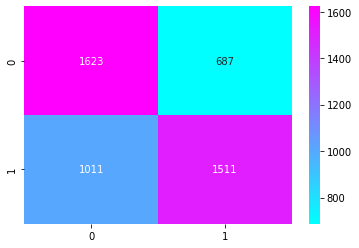

In [ ]:
sns.heatmap(matrix_happy, annot=True, cmap="cool", fmt='g')

In [ ]:
print(classification_report(happy_labels_Test_arr, y_pred_list_happy))

              precision    recall  f1-score   support

           0       0.62      0.70      0.66      2310
           1       0.69      0.60      0.64      2522

    accuracy                           0.65      4832
   macro avg       0.65      0.65      0.65      4832
weighted avg       0.65      0.65      0.65      4832



In [ ]:
print(balanced_accuracy_score(happy_labels_Test_arr, y_pred_list_happy))

0.6508625395223333


In [ ]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


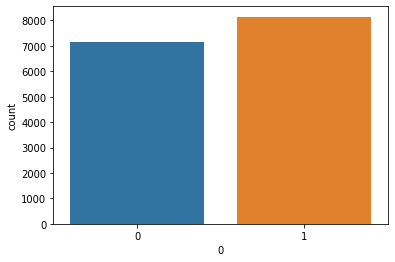

In [ ]:
sns.countplot(df_Happy_labels_Train.squeeze())

## Sad

In [ ]:
display(df_Sad_labels_Train)

,0
0,0
1,0
2,0
3,0
4,0
...,...
15285,0
15286,1
15287,0
15288,0


In [ ]:
labels_unique_sad, counts_sad = np.unique(df_Sad_labels_Train.squeeze(), return_counts=True)
print("Unique labels: {}".format(labels_unique_sad))

Unique labels: [0 1]


In [ ]:
class_weights_sad = []

for h in counts_sad:
  class_weights_sad.append(sum(counts_sad)/c)

In [ ]:
final_weights_sad = []

for h in df_Sad_labels_Train.squeeze():
  final_weights_sad.append(class_weights_sad[h])

sampler_sad = torch.utils.data.WeightedRandomSampler(final_weights_sad, len(df_Sad_labels_Train.squeeze()))

In [ ]:
sad_labels_Train_arr = df_Sad_labels_Train.to_numpy()
sad_labels_Test_arr = df_Sad_labels_Test.to_numpy()

In [ ]:
print(type(sad_labels_Train_arr))
print(sad_labels_Train_arr.dtype)

print(type(sad_labels_Test_arr))
print(sad_labels_Test_arr.dtype)

<class 'numpy.ndarray'>
int64
<class 'numpy.ndarray'>
int64


In [ ]:
print(type(modality_fusion_train_A_V_T))
print(modality_fusion_train_A_V_T.dtype)

print(type(modality_fusion_test_A_V_T))
print(modality_fusion_test_A_V_T.dtype)

<class 'numpy.ndarray'>
float64
<class 'numpy.ndarray'>
float64


In [ ]:
train_data_sad = MakeTrainSet(torch.FloatTensor(modality_fusion_train_A_V_T), 
                       torch.FloatTensor(sad_labels_Train_arr))

test_data_sad = MakeTestSet(torch.FloatTensor(modality_fusion_test_A_V_T))

In [ ]:
train_loader_sad = DataLoader(dataset=train_data_sad,
                              sampler= sampler_sad, 
                                batch_size=BATCH_SIZE)

test_loader_sad = DataLoader(dataset=test_data_sad, 
                         batch_size=1)

In [ ]:
print("Train dataset length ", len(train_data_sad))
print("Train loader length ", len(train_loader_sad))

print("Test dataset length ", len(test_data_sad))
print("Test loader length ", len(test_loader_sad))

Train dataset length  15290
Train loader length  478
Test dataset length  4832
Test loader length  4832


In [ ]:
model_sad = FeedForwardNN()
model_sad.to(device)
print(model_sad)

FeedForwardNN(
  (layer_1): Linear(in_features=877, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.4, inplace=False)
  (dropout4): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
criterion_sad = nn.BCEWithLogitsLoss()
optimizer_sad = optim.Adam(model_sad.parameters(), lr=LEARNING_RATE)

In [ ]:
model_sad.train()
for e in range(1, EPOCHS+1):
    epoch_loss_sad = 0
    epoch_acc_sad = 0
    for X_batch_sad, y_batch_sad in train_loader_sad:
        X_batch_sad = X_batch_sad.to(device)
        y_batch_sad = y_batch_sad.to(device)

        optimizer_sad.zero_grad()
        
        X_batch_sad = X_batch_sad.view(X_batch_sad.size(0), -1)
        y_pred_sad = model_sad(X_batch_sad)
        
        loss_sad = criterion_sad(y_pred_sad, y_batch_sad)
        acc_sad = calc_accuracy(y_pred_sad, y_batch_sad)
        
        loss_sad.backward()
        optimizer_sad.step()
        
        epoch_loss_sad += loss_sad.item()
        epoch_acc_sad += acc_sad.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss_sad/len(train_loader_sad):.5f} | Acc: {epoch_acc_sad/len(train_loader_sad):.3f}')

Epoch 001: | Loss: 0.65530 | Acc: 63.023
Epoch 002: | Loss: 0.62971 | Acc: 65.289
Epoch 003: | Loss: 0.62736 | Acc: 65.820
Epoch 004: | Loss: 0.61682 | Acc: 66.883
Epoch 005: | Loss: 0.62064 | Acc: 65.944
Epoch 006: | Loss: 0.61436 | Acc: 66.582
Epoch 007: | Loss: 0.61655 | Acc: 66.862
Epoch 008: | Loss: 0.61246 | Acc: 67.305
Epoch 009: | Loss: 0.60730 | Acc: 67.479
Epoch 010: | Loss: 0.60511 | Acc: 67.565
Epoch 011: | Loss: 0.60350 | Acc: 67.738
Epoch 012: | Loss: 0.60144 | Acc: 67.870
Epoch 013: | Loss: 0.60395 | Acc: 67.837
Epoch 014: | Loss: 0.59769 | Acc: 68.441
Epoch 015: | Loss: 0.60150 | Acc: 68.527
Epoch 016: | Loss: 0.59585 | Acc: 68.632
Epoch 017: | Loss: 0.60191 | Acc: 67.406
Epoch 018: | Loss: 0.59126 | Acc: 69.136
Epoch 019: | Loss: 0.59356 | Acc: 68.818
Epoch 020: | Loss: 0.58901 | Acc: 69.408
Epoch 021: | Loss: 0.59294 | Acc: 69.059
Epoch 022: | Loss: 0.58277 | Acc: 70.000
Epoch 023: | Loss: 0.58311 | Acc: 69.805
Epoch 024: | Loss: 0.57548 | Acc: 70.215
Epoch 025: | Los

In [ ]:
y_pred_list_sad = []

model_sad.eval()
with torch.no_grad():
    for X_batch_sad in test_loader_sad:
        X_batch_sad = X_batch_sad.to(device)

        X_batch_sad = X_batch_sad.view(X_batch_sad.size(0), -1)
        y_test_pred_sad = model_sad(X_batch_sad)
        
        y_test_pred_sad = torch.sigmoid(y_test_pred_sad)
        y_pred_tag_sad = torch.round(y_test_pred_sad)
        y_pred_list_sad.append(y_pred_tag_sad.cpu().numpy())

y_pred_list_sad = [h.squeeze().tolist() for h in y_pred_list_sad]

In [ ]:
matrix_sad = confusion_matrix(sad_labels_Test_arr, y_pred_list_sad)

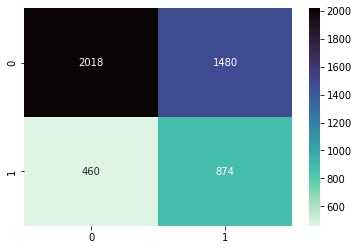

In [ ]:
sns.heatmap(matrix_sad, annot=True, cmap="mako_r", fmt='g')

In [ ]:
print(classification_report(sad_labels_Test_arr, y_pred_list_sad))

              precision    recall  f1-score   support

           0       0.81      0.58      0.68      3498
           1       0.37      0.66      0.47      1334

    accuracy                           0.60      4832
   macro avg       0.59      0.62      0.57      4832
weighted avg       0.69      0.60      0.62      4832



In [ ]:
print(balanced_accuracy_score(sad_labels_Test_arr, y_pred_list_sad))

0.616036750064076


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


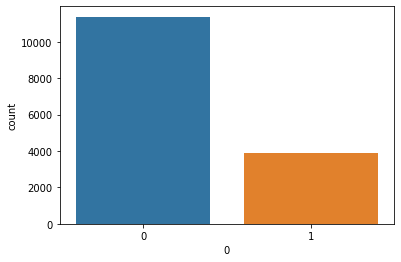

In [ ]:
sns.countplot(df_Sad_labels_Train.squeeze())

## Angry

In [ ]:
display(df_Angry_labels_Train)

,0
0,0
1,1
2,0
3,1
4,0
...,...
15285,0
15286,0
15287,0
15288,0


In [ ]:
labels_unique_angry, counts_angry = np.unique(df_Angry_labels_Train.squeeze(), return_counts=True)
print("Unique labels: {}".format(labels_unique_angry))

Unique labels: [0 1]


In [ ]:
class_weights_angry = []

for h in counts_angry:
  class_weights_angry.append(sum(counts_angry)/c)

In [ ]:
final_weights_angry = []

for h in df_Angry_labels_Train.squeeze():
  final_weights_angry.append(class_weights_angry[h])

sampler_angry = torch.utils.data.WeightedRandomSampler(final_weights_angry, len(df_Angry_labels_Train.squeeze()))

In [ ]:
angry_labels_Train_arr = df_Angry_labels_Train.to_numpy()
angry_labels_Test_arr = df_Angry_labels_Test.to_numpy()

In [ ]:
print(type(angry_labels_Train_arr))
print(angry_labels_Train_arr.dtype)

print(type(angry_labels_Test_arr))
print(angry_labels_Test_arr.dtype)

<class 'numpy.ndarray'>
int64
<class 'numpy.ndarray'>
int64


In [ ]:
print(type(modality_fusion_train_A_V_T))
print(modality_fusion_train_A_V_T.dtype)

print(type(modality_fusion_test_A_V_T))
print(modality_fusion_test_A_V_T.dtype)

<class 'numpy.ndarray'>
float64
<class 'numpy.ndarray'>
float64


In [ ]:
train_data_angry = MakeTrainSet(torch.FloatTensor(modality_fusion_train_A_V_T), 
                       torch.FloatTensor(angry_labels_Train_arr))

test_data_angry = MakeTestSet(torch.FloatTensor(modality_fusion_test_A_V_T))

In [ ]:
train_loader_angry = DataLoader(dataset=train_data_angry,
                                sampler= sampler_angry,  
                                batch_size=BATCH_SIZE)

test_loader_angry = DataLoader(dataset=test_data_angry, 
                         batch_size=1)

In [ ]:
print("Train dataset length ", len(train_data_angry))
print("Train loader length ", len(train_loader_angry))

print("Test dataset length ", len(test_data_angry))
print("Test loader length ", len(test_loader_angry))

Train dataset length  15290
Train loader length  478
Test dataset length  4832
Test loader length  4832


In [ ]:
model_angry = FeedForwardNN()
model_angry.to(device)
print(model_angry)

FeedForwardNN(
  (layer_1): Linear(in_features=877, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.4, inplace=False)
  (dropout4): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
criterion_angry = nn.BCEWithLogitsLoss()
optimizer_angry = optim.Adam(model_angry.parameters(), lr=LEARNING_RATE)

In [ ]:
model_angry.train()
for e in range(1, EPOCHS+1):
    epoch_loss_angry = 0
    epoch_acc_angry = 0
    for X_batch_angry, y_batch_angry in train_loader_angry:
        X_batch_angry = X_batch_angry.to(device)
        y_batch_angry = y_batch_angry.to(device)

        optimizer_angry.zero_grad()
        
        X_batch_angry = X_batch_angry.view(X_batch_angry.size(0), -1)
        y_pred_angry = model_angry(X_batch_angry)
        
        loss_angry = criterion_angry(y_pred_angry, y_batch_angry)
        acc_angry = calc_accuracy(y_pred_angry, y_batch_angry)
        
        loss_angry.backward()
        optimizer_angry.step()
        
        epoch_loss_angry += loss_angry.item()
        epoch_acc_angry += acc_angry.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss_angry/len(train_loader_angry):.5f} | Acc: {epoch_acc_angry/len(train_loader_angry):.3f}')

Epoch 001: | Loss: 0.63128 | Acc: 66.780
Epoch 002: | Loss: 0.60343 | Acc: 68.931
Epoch 003: | Loss: 0.59025 | Acc: 69.918
Epoch 004: | Loss: 0.58497 | Acc: 70.013
Epoch 005: | Loss: 0.58985 | Acc: 69.621
Epoch 006: | Loss: 0.58280 | Acc: 70.059
Epoch 007: | Loss: 0.57973 | Acc: 70.479
Epoch 008: | Loss: 0.57847 | Acc: 70.826
Epoch 009: | Loss: 0.57056 | Acc: 71.458
Epoch 010: | Loss: 0.58091 | Acc: 70.374
Epoch 011: | Loss: 0.57482 | Acc: 70.929
Epoch 012: | Loss: 0.57142 | Acc: 70.770
Epoch 013: | Loss: 0.57099 | Acc: 71.364
Epoch 014: | Loss: 0.56606 | Acc: 71.646
Epoch 015: | Loss: 0.56908 | Acc: 71.389
Epoch 016: | Loss: 0.55523 | Acc: 72.667
Epoch 017: | Loss: 0.55548 | Acc: 72.502
Epoch 018: | Loss: 0.54685 | Acc: 73.305
Epoch 019: | Loss: 0.55952 | Acc: 71.998
Epoch 020: | Loss: 0.55196 | Acc: 72.715
Epoch 021: | Loss: 0.54738 | Acc: 72.701
Epoch 022: | Loss: 0.54283 | Acc: 73.103
Epoch 023: | Loss: 0.54897 | Acc: 72.266
Epoch 024: | Loss: 0.54053 | Acc: 73.149
Epoch 025: | Los

In [ ]:
y_pred_list_angry = []

model_angry.eval()
with torch.no_grad():
    for X_batch_angry in test_loader_angry:
        X_batch_angry = X_batch_angry.to(device)

        X_batch_angry = X_batch_angry.view(X_batch_angry.size(0), -1)
        y_test_pred_angry = model_angry(X_batch_angry)
        
        y_test_pred_angry = torch.sigmoid(y_test_pred_angry)
        y_pred_tag_angry = torch.round(y_test_pred_angry)
        y_pred_list_angry.append(y_pred_tag_angry.cpu().numpy())

y_pred_list_angry = [h.squeeze().tolist() for h in y_pred_list_angry]

In [ ]:
matrix_angry = confusion_matrix(angry_labels_Test_arr, y_pred_list_angry)

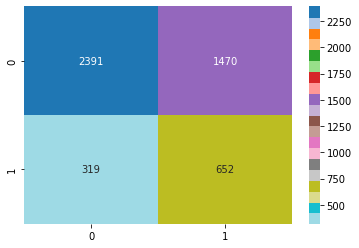

In [ ]:
sns.heatmap(matrix_angry, annot=True, cmap="tab20_r", fmt='g')

In [ ]:
print(classification_report(angry_labels_Test_arr, y_pred_list_angry))

              precision    recall  f1-score   support

           0       0.88      0.62      0.73      3861
           1       0.31      0.67      0.42       971

    accuracy                           0.63      4832
   macro avg       0.59      0.65      0.57      4832
weighted avg       0.77      0.63      0.67      4832



In [ ]:
print(balanced_accuracy_score(angry_labels_Test_arr, y_pred_list_angry))

0.645371163908754


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


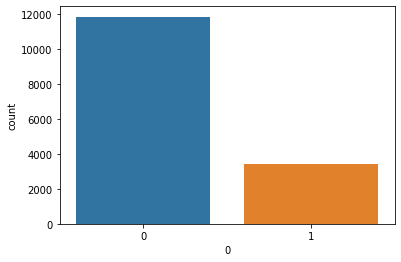

In [ ]:
sns.countplot(df_Angry_labels_Train.squeeze())

## Disgust

In [ ]:
display(df_Disgust_labels_Train)

,0
0,1
1,0
2,0
3,0
4,0
...,...
15285,1
15286,0
15287,0
15288,0


In [ ]:
labels_unique_disgust, counts_disgust = np.unique(df_Disgust_labels_Train.squeeze(), return_counts=True)
print("Unique labels: {}".format(labels_unique_disgust))

Unique labels: [0 1]


In [ ]:
class_weights_disgust = []

for h in counts_disgust:
  class_weights_disgust.append(sum(counts_disgust)/c)

In [ ]:
final_weights_disgust = []

for h in df_Disgust_labels_Train.squeeze():
  final_weights_disgust.append(class_weights_disgust[h])

sampler_disgust = torch.utils.data.WeightedRandomSampler(final_weights_disgust, len(df_Disgust_labels_Train.squeeze()))

In [ ]:
disgust_labels_Train_arr = df_Disgust_labels_Train.to_numpy()
disgust_labels_Test_arr = df_Disgust_labels_Test.to_numpy()

In [ ]:
print(type(disgust_labels_Train_arr))
print(disgust_labels_Train_arr.dtype)

print(type(disgust_labels_Test_arr))
print(disgust_labels_Test_arr.dtype)

<class 'numpy.ndarray'>
int64
<class 'numpy.ndarray'>
int64


In [ ]:
print(type(modality_fusion_train_A_V_T))
print(modality_fusion_train_A_V_T.dtype)

print(type(modality_fusion_test_A_V_T))
print(modality_fusion_test_A_V_T.dtype)

<class 'numpy.ndarray'>
float64
<class 'numpy.ndarray'>
float64


In [ ]:
train_data_disgust = MakeTrainSet(torch.FloatTensor(modality_fusion_train_A_V_T), 
                       torch.FloatTensor(disgust_labels_Train_arr))

test_data_disgust = MakeTestSet(torch.FloatTensor(modality_fusion_test_A_V_T))

In [ ]:
train_loader_disgust = DataLoader(dataset=train_data_disgust, 
                                  sampler= sampler_disgust,
                                batch_size=BATCH_SIZE)

test_loader_disgust = DataLoader(dataset=test_data_disgust, 
                         batch_size=1)

In [ ]:
print("Train dataset length ", len(train_data_disgust))
print("Train loader length ", len(train_loader_disgust))

print("Test dataset length ", len(test_data_disgust))
print("Test loader length ", len(test_loader_disgust))

Train dataset length  15290
Train loader length  478
Test dataset length  4832
Test loader length  4832


In [ ]:
model_disgust = FeedForwardNN()
model_disgust.to(device)
print(model_disgust)

FeedForwardNN(
  (layer_1): Linear(in_features=877, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.4, inplace=False)
  (dropout4): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
criterion_disgust = nn.BCEWithLogitsLoss()
optimizer_disgust = optim.Adam(model_disgust.parameters(), lr=LEARNING_RATE)

In [ ]:
model_disgust.train()
for e in range(1, EPOCHS+1):
    epoch_loss_disgust = 0
    epoch_acc_disgust = 0
    for X_batch_disgust, y_batch_disgust in train_loader_disgust:
        X_batch_disgust = X_batch_disgust.to(device)
        y_batch_disgust = y_batch_disgust.to(device)

        optimizer_disgust.zero_grad()
        
        X_batch_disgust = X_batch_disgust.view(X_batch_disgust.size(0), -1)
        y_pred_disgust = model_disgust(X_batch_disgust)
        
        loss_disgust = criterion_disgust(y_pred_disgust, y_batch_disgust)
        acc_disgust = calc_accuracy(y_pred_disgust, y_batch_disgust)
        
        loss_disgust.backward()
        optimizer_disgust.step()
        
        epoch_loss_disgust += loss_disgust.item()
        epoch_acc_disgust += acc_disgust.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss_disgust/len(train_loader_disgust):.5f} | Acc: {epoch_acc_disgust/len(train_loader_disgust):.3f}')

Epoch 001: | Loss: 0.54662 | Acc: 73.868
Epoch 002: | Loss: 0.52094 | Acc: 75.178
Epoch 003: | Loss: 0.51743 | Acc: 74.870
Epoch 004: | Loss: 0.51726 | Acc: 75.243
Epoch 005: | Loss: 0.51346 | Acc: 75.343
Epoch 006: | Loss: 0.51836 | Acc: 75.374
Epoch 007: | Loss: 0.50704 | Acc: 76.236
Epoch 008: | Loss: 0.50579 | Acc: 75.962
Epoch 009: | Loss: 0.49700 | Acc: 76.431
Epoch 010: | Loss: 0.49707 | Acc: 76.743
Epoch 011: | Loss: 0.49644 | Acc: 76.628
Epoch 012: | Loss: 0.49778 | Acc: 76.596
Epoch 013: | Loss: 0.49364 | Acc: 77.065
Epoch 014: | Loss: 0.49456 | Acc: 77.067
Epoch 015: | Loss: 0.48374 | Acc: 77.506
Epoch 016: | Loss: 0.49362 | Acc: 76.603
Epoch 017: | Loss: 0.47915 | Acc: 78.002
Epoch 018: | Loss: 0.47579 | Acc: 77.847
Epoch 019: | Loss: 0.46807 | Acc: 78.259
Epoch 020: | Loss: 0.47246 | Acc: 78.013
Epoch 021: | Loss: 0.46876 | Acc: 78.692
Epoch 022: | Loss: 0.47226 | Acc: 78.364
Epoch 023: | Loss: 0.46342 | Acc: 78.864
Epoch 024: | Loss: 0.46970 | Acc: 78.238
Epoch 025: | Los

In [ ]:
y_pred_list_disgust = []

model_disgust.eval()
with torch.no_grad():
    for X_batch_disgust in test_loader_disgust:
        X_batch_disgust = X_batch_disgust.to(device)

        X_batch_disgust = X_batch_disgust.view(X_batch_disgust.size(0), -1)
        y_test_pred_disgust = model_disgust(X_batch_disgust)
        
        y_test_pred_disgust = torch.sigmoid(y_test_pred_disgust)
        y_pred_tag_disgust = torch.round(y_test_pred_disgust)
        y_pred_list_disgust.append(y_pred_tag_disgust.cpu().numpy())

y_pred_list_disgust = [h.squeeze().tolist() for h in y_pred_list_disgust]

In [ ]:
matrix_disgust = confusion_matrix(disgust_labels_Test_arr, y_pred_list_disgust)

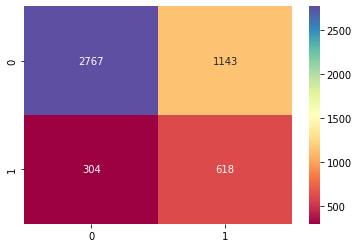

In [ ]:
sns.heatmap(matrix_disgust, annot=True, cmap="Spectral", fmt='g')

In [ ]:
print(classification_report(disgust_labels_Test_arr, y_pred_list_disgust))

              precision    recall  f1-score   support

           0       0.90      0.71      0.79      3910
           1       0.35      0.67      0.46       922

    accuracy                           0.70      4832
   macro avg       0.63      0.69      0.63      4832
weighted avg       0.80      0.70      0.73      4832



In [ ]:
print(balanced_accuracy_score(disgust_labels_Test_arr, y_pred_list_disgust))

0.6889773149663525


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


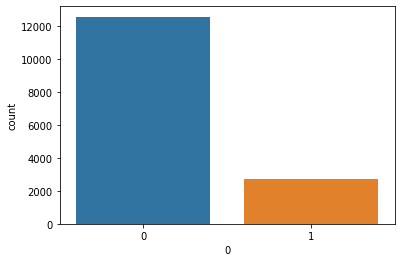

In [ ]:
sns.countplot(df_Disgust_labels_Train.squeeze())

## Surprise

In [ ]:
display(df_Surprise_labels_Train)

,0
0,0
1,0
2,0
3,0
4,0
...,...
15285,0
15286,0
15287,0
15288,0


In [ ]:
labels_unique_surprise, counts_surprise = np.unique(df_Surprise_labels_Train.squeeze(), return_counts=True)
print("Unique labels: {}".format(labels_unique_surprise))

Unique labels: [0 1]


In [ ]:
class_weights_surprise = []

for h in counts_surprise:
  class_weights_surprise.append(sum(counts_surprise)/c)

In [ ]:
final_weights_surprise = []

for h in df_Surprise_labels_Train.squeeze():
  final_weights_surprise.append(class_weights_surprise[h])

sampler_surprise = torch.utils.data.WeightedRandomSampler(final_weights_surprise, len(df_Surprise_labels_Train.squeeze()))

In [ ]:
surprise_labels_Train_arr = df_Surprise_labels_Train.to_numpy()
surprise_labels_Test_arr = df_Surprise_labels_Test.to_numpy()

In [ ]:
print(type(surprise_labels_Train_arr))
print(surprise_labels_Train_arr.dtype)

print(type(surprise_labels_Test_arr))
print(surprise_labels_Test_arr.dtype)

<class 'numpy.ndarray'>
int64
<class 'numpy.ndarray'>
int64


In [ ]:
print(type(modality_fusion_train_A_V_T))
print(modality_fusion_train_A_V_T.dtype)

print(type(modality_fusion_test_A_V_T))
print(modality_fusion_test_A_V_T.dtype)

<class 'numpy.ndarray'>
float64
<class 'numpy.ndarray'>
float64


In [ ]:
train_data_surprise = MakeTrainSet(torch.FloatTensor(modality_fusion_train_A_V_T), 
                       torch.FloatTensor(surprise_labels_Train_arr))

test_data_surprise = MakeTestSet(torch.FloatTensor(modality_fusion_test_A_V_T))

In [ ]:
train_loader_surprise = DataLoader(dataset=train_data_surprise, 
                                   sampler= sampler_surprise,
                                batch_size=BATCH_SIZE)

test_loader_surprise = DataLoader(dataset=test_data_surprise, 
                         batch_size=1)

In [ ]:
print("Train dataset length ", len(train_data_surprise))
print("Train loader length ", len(train_loader_surprise))

print("Test dataset length ", len(test_data_surprise))
print("Test loader length ", len(test_loader_surprise))

Train dataset length  15290
Train loader length  478
Test dataset length  4832
Test loader length  4832


In [ ]:
model_surprise = FeedForwardNN()
model_surprise.to(device)
print(model_surprise)

FeedForwardNN(
  (layer_1): Linear(in_features=877, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.4, inplace=False)
  (dropout4): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
criterion_surprise = nn.BCEWithLogitsLoss()
optimizer_surprise = optim.Adam(model_surprise.parameters(), lr=LEARNING_RATE)

In [ ]:
model_surprise.train()
for e in range(1, EPOCHS+1):
    epoch_loss_surprise = 0
    epoch_acc_surprise = 0
    for X_batch_surprise, y_batch_surprise in train_loader_surprise:
        X_batch_surprise = X_batch_surprise.to(device)
        y_batch_surprise = y_batch_surprise.to(device)

        optimizer_surprise.zero_grad()
        
        X_batch_surprise = X_batch_surprise.view(X_batch_surprise.size(0), -1)
        y_pred_surprise = model_surprise(X_batch_surprise)
        
        loss_surprise = criterion_surprise(y_pred_surprise, y_batch_surprise)
        acc_surprise = calc_accuracy(y_pred_surprise, y_batch_surprise)
        
        loss_surprise.backward()
        optimizer_surprise.step()
        
        epoch_loss_surprise += loss_surprise.item()
        epoch_acc_surprise += acc_surprise.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss_surprise/len(train_loader_surprise):.5f} | Acc: {epoch_acc_surprise/len(train_loader_surprise):.3f}')

Epoch 001: | Loss: 0.68749 | Acc: 57.544
Epoch 002: | Loss: 0.65270 | Acc: 62.429
Epoch 003: | Loss: 0.65012 | Acc: 62.939
Epoch 004: | Loss: 0.64434 | Acc: 63.040
Epoch 005: | Loss: 0.64207 | Acc: 63.504
Epoch 006: | Loss: 0.63061 | Acc: 65.013
Epoch 007: | Loss: 0.63618 | Acc: 64.245
Epoch 008: | Loss: 0.62851 | Acc: 65.056
Epoch 009: | Loss: 0.62846 | Acc: 64.437
Epoch 010: | Loss: 0.61674 | Acc: 65.981
Epoch 011: | Loss: 0.61656 | Acc: 66.134
Epoch 012: | Loss: 0.62030 | Acc: 65.678
Epoch 013: | Loss: 0.60777 | Acc: 66.948
Epoch 014: | Loss: 0.60598 | Acc: 67.146
Epoch 015: | Loss: 0.60153 | Acc: 67.404
Epoch 016: | Loss: 0.59166 | Acc: 68.368
Epoch 017: | Loss: 0.59326 | Acc: 68.496
Epoch 018: | Loss: 0.58533 | Acc: 68.048
Epoch 019: | Loss: 0.57793 | Acc: 69.726
Epoch 020: | Loss: 0.57283 | Acc: 69.427
Epoch 021: | Loss: 0.56683 | Acc: 69.923
Epoch 022: | Loss: 0.55554 | Acc: 70.822
Epoch 023: | Loss: 0.54749 | Acc: 71.556
Epoch 024: | Loss: 0.54876 | Acc: 71.563
Epoch 025: | Los

In [ ]:
y_pred_list_surprise = []

model_surprise.eval()
with torch.no_grad():
    for X_batch_surprise in test_loader_surprise:
        X_batch_surprise = X_batch_surprise.to(device)

        X_batch_surprise = X_batch_surprise.view(X_batch_surprise.size(0), -1)
        y_test_pred_surprise = model_surprise(X_batch_surprise)
        
        y_test_pred_surprise = torch.sigmoid(y_test_pred_surprise)
        y_pred_tag_surprise = torch.round(y_test_pred_surprise)
        y_pred_list_surprise.append(y_pred_tag_surprise.cpu().numpy())

y_pred_list_surprise = [h.squeeze().tolist() for h in y_pred_list_surprise]

In [ ]:
matrix_surprise = confusion_matrix(surprise_labels_Test_arr, y_pred_list_surprise)

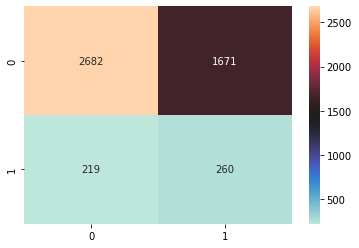

In [ ]:
sns.heatmap(matrix_surprise, annot=True, cmap="icefire", fmt='g')

In [ ]:
print(classification_report(surprise_labels_Test_arr, y_pred_list_surprise))

              precision    recall  f1-score   support

           0       0.92      0.62      0.74      4353
           1       0.13      0.54      0.22       479

    accuracy                           0.61      4832
   macro avg       0.53      0.58      0.48      4832
weighted avg       0.85      0.61      0.69      4832



In [ ]:
print(balanced_accuracy_score(surprise_labels_Test_arr, y_pred_list_surprise))

0.5794621519389838


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


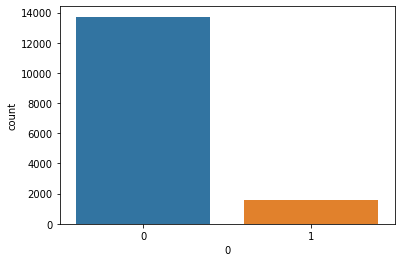

In [ ]:
sns.countplot(df_Surprise_labels_Train.squeeze())

## Fear

In [ ]:
display(df_Fear_labels_Train)

,0
0,1
1,0
2,0
3,0
4,0
...,...
15285,0
15286,0
15287,1
15288,0


In [ ]:
labels_unique_fear, counts_fear = np.unique(df_Fear_labels_Train.squeeze(), return_counts=True)
print("Unique labels: {}".format(labels_unique_fear))

Unique labels: [0 1]


In [ ]:
class_weights_fear = []

for h in counts_fear:
  class_weights_fear.append(sum(counts_fear)/c)

In [ ]:
final_weights_fear = []

for h in df_Fear_labels_Train.squeeze():
  final_weights_fear.append(class_weights_fear[h])

sampler_fear = torch.utils.data.WeightedRandomSampler(final_weights_fear, len(df_Fear_labels_Train.squeeze()))

In [ ]:
fear_labels_Train_arr = df_Fear_labels_Train.to_numpy()
fear_labels_Test_arr = df_Fear_labels_Test.to_numpy()

In [ ]:
print(type(fear_labels_Train_arr))
print(fear_labels_Train_arr.dtype)

print(type(fear_labels_Test_arr))
print(fear_labels_Test_arr.dtype)

<class 'numpy.ndarray'>
int64
<class 'numpy.ndarray'>
int64


In [ ]:
print(type(modality_fusion_train_A_V_T))
print(modality_fusion_train_A_V_T.dtype)

print(type(modality_fusion_test_A_V_T))
print(modality_fusion_test_A_V_T.dtype)

<class 'numpy.ndarray'>
float64
<class 'numpy.ndarray'>
float64


In [ ]:
train_data_fear = MakeTrainSet(torch.FloatTensor(modality_fusion_train_A_V_T), 
                       torch.FloatTensor(fear_labels_Train_arr))

test_data_fear = MakeTestSet(torch.FloatTensor(modality_fusion_test_A_V_T))

In [ ]:
train_loader_fear = DataLoader(dataset=train_data_fear,
                               sampler= sampler_fear,
                                batch_size=BATCH_SIZE)

test_loader_fear = DataLoader(dataset=test_data_fear, 
                         batch_size=1)

In [ ]:
print("Train dataset length ", len(train_data_fear))
print("Train loader length ", len(train_loader_fear))

print("Test dataset length ", len(test_data_fear))
print("Test loader length ", len(test_loader_fear))

Train dataset length  15290
Train loader length  478
Test dataset length  4832
Test loader length  4832


In [ ]:
model_fear = FeedForwardNN()
model_fear.to(device)
print(model_fear)

FeedForwardNN(
  (layer_1): Linear(in_features=877, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.4, inplace=False)
  (dropout4): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
criterion_fear = nn.BCEWithLogitsLoss()
optimizer_fear = optim.Adam(model_fear.parameters(), lr=LEARNING_RATE)

In [ ]:
model_fear.train()
for e in range(1, EPOCHS+1):
    epoch_loss_fear = 0
    epoch_acc_fear = 0
    for X_batch_fear, y_batch_fear in train_loader_fear:
        X_batch_fear = X_batch_fear.to(device)
        y_batch_fear = y_batch_fear.to(device)

        optimizer_fear.zero_grad()
        
        X_batch_fear = X_batch_fear.view(X_batch_fear.size(0), -1)
        y_pred_fear = model_fear(X_batch_fear)
        
        loss_fear = criterion_fear(y_pred_fear, y_batch_fear)
        acc_fear = calc_accuracy(y_pred_fear, y_batch_fear)
        
        loss_fear.backward()
        optimizer_fear.step()
        
        epoch_loss_fear += loss_fear.item()
        epoch_acc_fear += acc_fear.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss_fear/len(train_loader_fear):.5f} | Acc: {epoch_acc_fear/len(train_loader_fear):.3f}')

Epoch 001: | Loss: 0.66628 | Acc: 62.814
Epoch 002: | Loss: 0.62946 | Acc: 65.960
Epoch 003: | Loss: 0.61531 | Acc: 67.594
Epoch 004: | Loss: 0.60934 | Acc: 67.816
Epoch 005: | Loss: 0.60312 | Acc: 68.764
Epoch 006: | Loss: 0.59022 | Acc: 70.354
Epoch 007: | Loss: 0.57803 | Acc: 71.253
Epoch 008: | Loss: 0.57669 | Acc: 71.397
Epoch 009: | Loss: 0.57054 | Acc: 71.711
Epoch 010: | Loss: 0.56722 | Acc: 72.031
Epoch 011: | Loss: 0.55608 | Acc: 72.504
Epoch 012: | Loss: 0.55308 | Acc: 72.918
Epoch 013: | Loss: 0.54594 | Acc: 73.548
Epoch 014: | Loss: 0.53852 | Acc: 73.994
Epoch 015: | Loss: 0.53642 | Acc: 73.703
Epoch 016: | Loss: 0.52324 | Acc: 75.046
Epoch 017: | Loss: 0.50928 | Acc: 75.921
Epoch 018: | Loss: 0.51171 | Acc: 75.402
Epoch 019: | Loss: 0.50283 | Acc: 76.410
Epoch 020: | Loss: 0.49091 | Acc: 77.402
Epoch 021: | Loss: 0.47588 | Acc: 77.839
Epoch 022: | Loss: 0.47831 | Acc: 78.211
Epoch 023: | Loss: 0.46302 | Acc: 78.674
Epoch 024: | Loss: 0.45644 | Acc: 78.994
Epoch 025: | Los

In [ ]:
y_pred_list_fear = []

model_fear.eval()
with torch.no_grad():
    for X_batch_fear in test_loader_fear:
        X_batch_fear = X_batch_fear.to(device)

        X_batch_fear = X_batch_fear.view(X_batch_fear.size(0), -1)
        y_test_pred_fear = model_fear(X_batch_fear)
        
        y_test_pred_fear = torch.sigmoid(y_test_pred_fear)
        y_pred_tag_fear = torch.round(y_test_pred_fear)
        y_pred_list_fear.append(y_pred_tag_fear.cpu().numpy())

y_pred_list_fear = [h.squeeze().tolist() for h in y_pred_list_fear]

In [ ]:
matrix_fear = confusion_matrix(fear_labels_Test_arr, y_pred_list_fear)

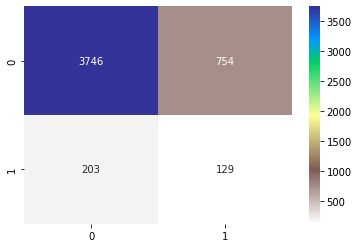

In [ ]:
sns.heatmap(matrix_fear, annot=True, cmap="terrain_r", fmt='g')

In [ ]:
print(classification_report(fear_labels_Test_arr, y_pred_list_fear))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      4500
           1       0.15      0.39      0.21       332

    accuracy                           0.80      4832
   macro avg       0.55      0.61      0.55      4832
weighted avg       0.89      0.80      0.84      4832



In [ ]:
print(balanced_accuracy_score(fear_labels_Test_arr, y_pred_list_fear))

0.6104993306559572
